Ignacio Vellido Expósito

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [54]:
results = [
  ["Baseline", 44, 0.26713, 0.881863, 0.644436, 0.624672, 54.959, "(53x53x64)"],
  ["BatchNormalization", 61, 0.26685, 0.88995, 0.709552, 0.675148, 32.900, "(53x53x64)"],
  ["Añadiendo convoluciones", 38, 0.328187, 0.877485, 0.659633, 0.631239, 35.227, "(53x53x64)"],
  ["Añadiendo deconvoluciones", 34, 0.298791, 0.88588, 0.638742, 0.622448, 32.079, "(53x53x64)"],
  ["Stride = [1 1]", 39, 0.359459, 0.856539, 0.627386, 0.604717, 36.008, "(53x53x64)"],
  ["Anterior sin BatchNormalization", 86, 0.247664, 0.895049, 0.688428, 0.673189, 117.481, "(53x53x64)"],
  ["Con 128 unidades por capa", 32, 0.447622, 0.817212, 0.557186, 0.574024, 72.910, "(53x53x128)"],
  ["Añadiendo Dropout", 52, 0.228375,  0.906868, 0.68486, 0.68089, 119.627, "(53x53x128)"],
  ["Subiendo un nivel", 36, 0.402376,  0.844556,  0.590228, 0.585934, 62.383, "(107x107x64)"],
  ["Bajando un nivel", 88, 0.244121,  0.906718,  0.68557, 0.751832, 208.208, "(26x26x128)"]
]

pd.DataFrame(results, columns=["Arquitecture", "Epochs","Test Loss", "Test Accuracy", "Train IoU", "Test IoU", "Time(s)", "Latent representation"])

,Arquitecture,Epochs,Test Loss,Test Accuracy,Train IoU,Test IoU,Time(s),Latent representation
0,Baseline,44,0.267130,0.881863,0.644436,0.624672,54.959,(53x53x64)
1,BatchNormalization,61,0.266850,0.889950,0.709552,0.675148,32.900,(53x53x64)
2,Añadiendo convoluciones,38,0.328187,0.877485,0.659633,0.631239,35.227,(53x53x64)
3,Añadiendo deconvoluciones,34,0.298791,0.885880,0.638742,0.622448,32.079,(53x53x64)
4,Stride = [1 1],39,0.359459,0.856539,0.627386,0.604717,36.008,(53x53x64)
5,Anterior sin BatchNormalization,86,0.247664,0.895049,0.688428,0.673189,117.481,(53x53x64)
6,Con 128 unidades por capa,32,0.447622,0.817212,0.557186,0.574024,72.910,(53x53x128)
7,Añadiendo Dropout,52,0.228375,0.906868,0.684860,0.680890,119.627,(53x53x128)
8,Subiendo un nivel,36,0.402376,0.844556,0.590228,0.585934,62.383,(107x107x64)
9,Bajando un nivel,88,0.244121,0.906718,0.685570,0.751832,208.208,(26x26x128)


**Conclusiones**

- Aunque aplicar BatchNormalization incrementa ligeramente los resultados también hace que la curva de aprendizaje sea extremadamente ruidosa. Además, a la hora de experimentar con las arquitecturas (no solo lo mostrado en la tabla) se nota una cierta tendencia a empeorar la calidad de este tipo de redes.

<br>

- Cuando aumentamos el número de unidades es necesario empezar a incluir regularización.

<br>

- Por las dimensiones de entrada si queremos bajar hasta un tercer nivel es necesario aplicar padding a las representaciones intermedias, de forma que el upsampling se realice correctamente.

<br>

- A lo largo de las diferentes pruebas se ha visto que los resultados son un tanto ruidosos. La forma de la persona suele devolverse con más intensidad, pero en muchos casos existe cierta confusión con el fondo cercano. 

- Únicamente la última red es la que define con más precisión y fuerza los peatones, aunque deja una especia de *margin boundary* alrededor de las figuras.


In [44]:
################################################################################
# Libraries
################################################################################

# Import layers
import tensorflow as tf

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.models import Model

from tensorflow.keras.layers.experimental.preprocessing import Normalization

################################################################################

import os
import time
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, auc

# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set numpy seed
np.random.seed(12345)

In [5]:
################################################################################
# Load data
################################################################################

# Adaptación de:
# https://stackoverflow.com/questions/30230592/loading-all-images-using-imread-from-a-given-folder
def load_images_from_folder(folder, resize_shape = None, subset_shape = None, color=1):
  """ Load images resizing and getting a random subset of shape @subset_shape
  if indicated """
  images = []

  for filename in sorted(os.listdir(folder)):
    img = cv2.imread(os.path.join(folder,filename), color)
    if img is not None:
      if resize_shape is not None:
        img = cv2.resize(img, resize_shape)

      shape = img.shape
      if subset_shape is not None:
        i = np.random.randint(0,shape[0] - subset_shape[0])
        j = np.random.randint(0,shape[1] - subset_shape[1])
        img = img[i : i+subset_shape[0], j : j+subset_shape[1]]

      images.append(img)

  return np.array(images)

path = "/content/drive/MyDrive/VC-T3/data_segmentation/"
trn_img = load_images_from_folder(path + "train/images", (214,214))
trn_msk = load_images_from_folder(path + "train/mask", (214,214), color=0)

tst_img = load_images_from_folder(path + "test/images", (214,214))
tst_msk = load_images_from_folder(path + "test/mask", (214,214), color=0)

print("Loaded train images with shape {}".format(trn_img.shape))
print("Loaded test images with shape {}".format(tst_img.shape))

Loaded train images with shape (96, 214, 214, 3)
Loaded test images with shape (74, 214, 214, 3)


In [6]:
# Apply thresholding in image mask
def mask_thresholding(img):
  _, out = cv2.threshold(img, 0, 1, cv2.THRESH_BINARY)

  return out

trn_x = trn_img
tst_x = tst_img
trn_y = np.array(list(map(mask_thresholding, trn_msk)))
tst_y = np.array(list(map(mask_thresholding, tst_msk)))

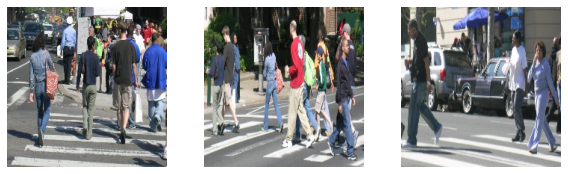

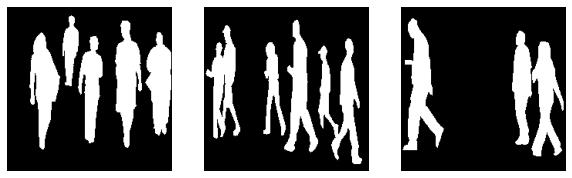

In [ ]:
################################################################################
# Visualize data
################################################################################
plt.figure(figsize=(10, 10))

for i, img in enumerate(trn_x[:3]):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.axis("off")

plt.show()

plt.figure(figsize=(10, 10))
for i, img in enumerate(trn_y[:3]):
  ax = plt.subplot(1, 3, i + 1)
  plt.imshow(img, "gray")
  plt.axis("off")

plt.show()

In [46]:
################################################################################
# Define model
################################################################################

input_shape = (214,214,3)

# Input layer
input = Input(shape=input_shape)
m = Normalization()(input) # Zerocenter normalization

# Down
m = Conv2D(128, (3,3), padding="same", activation="relu")(m)
m = Conv2D(128, (3,3), padding="same", activation="relu")(m)
m = MaxPooling2D((2,2))(m)
m = Dropout(0.1)(m)
# m = BatchNormalization()(m)

m = Conv2D(128, (3,3), padding="same", activation="relu")(m)
m = Conv2D(128, (3,3), padding="same", activation="relu")(m)
m = MaxPooling2D((2,2))(m)

m = Conv2D(128, (3,3), padding="same", activation="relu")(m)
m = Conv2D(128, (3,3), padding="same", activation="relu")(m)
m = MaxPooling2D((2,2))(m)

# m = MaxPooling2D((2,2), strides=(2,2))(m)
# m = BatchNormalization()(m)

m = Conv2D(128, (3,3), padding="same", activation="relu")(m)
m = Conv2D(128, (3,3), padding="same")(m)

# Up
m = Conv2DTranspose(128, (4,4), padding="same")(m)
m = Conv2DTranspose(128, (4,4), strides=(2,2), padding="same")(m)

m = Conv2DTranspose(128, (4,4), padding="same")(m)
m = Conv2DTranspose(128, (4,4), strides=(2,2), padding="same")(m)
m = ZeroPadding2D()(m)

m = Conv2DTranspose(128, (4,4), padding="same")(m)
m = Conv2DTranspose(128, (4,4), strides=(2,2))(m)
# m = BatchNormalization()(m)

output = Conv2D(2, (1,1), padding="same", activation="softmax")(m)

model = Model(input, output)
model.summary()

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 214, 214, 3)]     0         
_________________________________________________________________
normalization_22 (Normalizat (None, 214, 214, 3)       7         
_________________________________________________________________
conv2d_176 (Conv2D)          (None, 214, 214, 128)     3584      
_________________________________________________________________
conv2d_177 (Conv2D)          (None, 214, 214, 128)     147584    
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 107, 107, 128)     0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 107, 107, 128)     0         
_________________________________________________________________
conv2d_178 (Conv2D)          (None, 107, 107, 128)     147

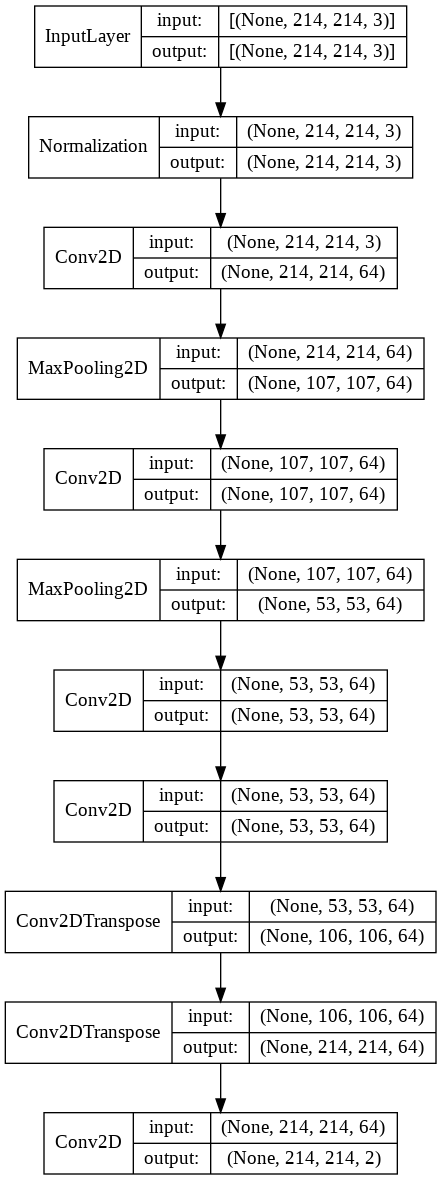

In [ ]:
tf.keras.utils.plot_model(model, show_layer_names=False, show_shapes=True)

In [8]:
# Mean Intersection Over Union metric. From:
# https://github.com/tensorflow/tensorflow/issues/32875#issuecomment-707316950

class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
  def __init__(self,
               y_true=None,
               y_pred=None,
               num_classes=None,
               name=None,
               dtype=None):
    super(UpdatedMeanIoU, self).__init__(num_classes = num_classes,name=name, dtype=dtype)

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred = tf.math.argmax(y_pred, axis=-1)
    return super().update_state(y_true, y_pred, sample_weight)

In [47]:
################################################################################
# Fit model
################################################################################

# Parameters
epochs = 200
batch_size = 24
lr = "auto"

# Compile model
opt = tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy', UpdatedMeanIoU(num_classes=2, name="IoU")]
)

# EarlyStopping callback
early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_IoU', 
                                                  patience=10,
                                                  mode="max", # We want to maximize IoU
                                                  restore_best_weights=True)

# Fitting
t_start = time.perf_counter()
history = model.fit(trn_x, trn_y,
                    validation_split=0.2,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    callbacks=[early_callback],
                    verbose=1
          )
t_span = time.perf_counter() - t_start
t_span

Epoch 1/200
4/4 [==============================] - 5s 875ms/step - loss: 1.9966 - accuracy: 0.4092 - IoU: 0.2518 - val_loss: 2.1924 - val_accuracy: 0.2280 - val_IoU: 0.1195
Epoch 2/200
4/4 [==============================] - 2s 567ms/step - loss: 1.3759 - accuracy: 0.4050 - IoU: 0.2494 - val_loss: 0.5919 - val_accuracy: 0.7944 - val_IoU: 0.4020
Epoch 3/200
4/4 [==============================] - 2s 532ms/step - loss: 0.9572 - accuracy: 0.6309 - IoU: 0.3777 - val_loss: 0.7009 - val_accuracy: 0.4722 - val_IoU: 0.2894
Epoch 4/200
4/4 [==============================] - 2s 567ms/step - loss: 0.6409 - accuracy: 0.6823 - IoU: 0.3930 - val_loss: 0.5624 - val_accuracy: 0.7955 - val_IoU: 0.3977
Epoch 5/200
4/4 [==============================] - 2s 536ms/step - loss: 0.5577 - accuracy: 0.7996 - IoU: 0.3998 - val_loss: 0.5496 - val_accuracy: 0.7955 - val_IoU: 0.3977
Epoch 6/200
4/4 [==============================] - 2s 569ms/step - loss: 0.5343 - accuracy: 0.7996 - IoU: 0.3998 - val_loss: 0.5187 - v

208.20758848800028

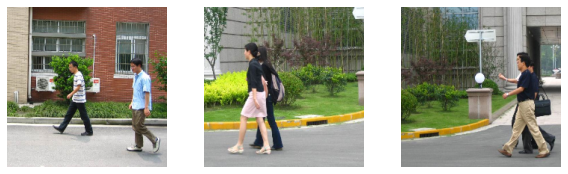

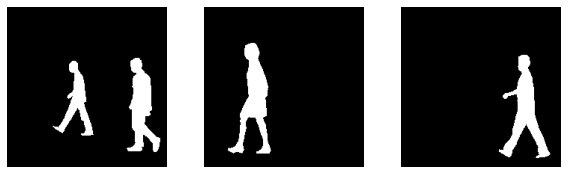

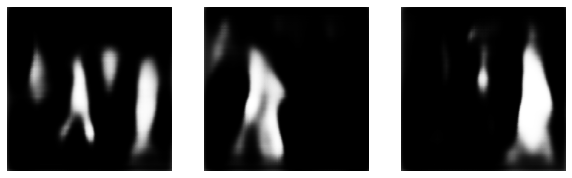

In [51]:
################################################################################
# Visualize predictions
################################################################################
pred = model.predict(tst_x)

plt.figure(figsize=(10, 10))

for i, img in enumerate(tst_x[:3]):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.axis("off")

plt.show()

plt.figure(figsize=(10, 10))
for i, img in enumerate(tst_y[:3]):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(img, "gray")
  plt.axis("off")

plt.show()

plt.figure(figsize=(10, 10))
for i, img in enumerate(pred[:3]):
  ax = plt.subplot(1, 3, i + 1)
  plt.imshow(img[:,:,1], "gray")
  plt.axis("off")

plt.show()

In [11]:
################################################################################
# Test model
################################################################################

def plot_history(history):
  acc = history.history["accuracy"]
  val_acc = history.history["val_accuracy"]

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  iou = history.history["IoU"]
  val_iou = history.history["val_IoU"]

  epochs = range(1, len(acc)+1)

  plt.plot(epochs, acc, "r", label="Training acc")
  plt.plot(epochs, val_acc, "b", label="Validation acc")
  plt.title("Training and validation accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.figure()

  plt.plot(epochs, loss, "r", label="Training loss")
  plt.plot(epochs, val_loss, "b", label="Validation loss")
  plt.title("Training and validation loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.figure()

  plt.plot(epochs, iou, "r", label="Training IoU")
  plt.plot(epochs, val_iou, "b", label="Validation IoU")
  plt.title("Training and validation IoU")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.figure()

  plt.show()

# ------------------------------------------------------------------------------

def get_scores(model, x, y, subset):
  loss, acc, iou = model.evaluate(x, y, verbose=0)

  pred = model.predict(x)
  pred = (pred>.5)

  metrics = pd.DataFrame(columns=["Loss", "Accuracy", "IoU"])
  metrics.loc[0] = [loss, acc, iou]
  
  print(metrics)

# ------------------------------------------------------------------------------

def evaluate_model(model, history, trn_x, trn_y, tst_x, tst_y):
  print(model.summary())

  print("Max Epochs: {}".format(epochs))
  print("Last epoch: {}".format(len(history.epoch)))
  print("Batch size: {}".format(batch_size))
  print("Learning r: {}".format(lr))
  print("Computational time: %.3f s." % t_span)

  print("Train-----------------------------\n")
  get_scores(model, trn_x, trn_y, "Train")
  print("Test------------------------------\n")
  get_scores(model, tst_x, tst_y, "Test")
  print("\n")

  plot_history(history)

Latent dimension shape: (53, 53, 64)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 214, 214, 3)]     0         
_________________________________________________________________
normalization_1 (Normalizati (None, 214, 214, 3)       7         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 214, 214, 64)      1792      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 107, 107, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 107, 107, 64)      36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 53, 53, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)     

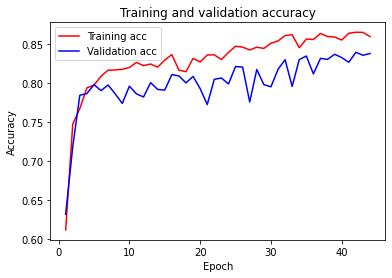

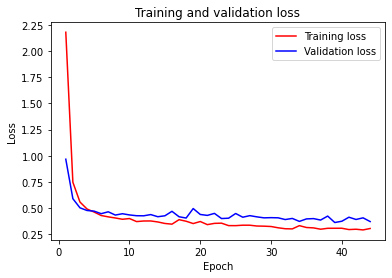

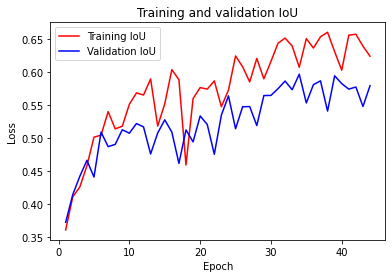

<Figure size 432x288 with 0 Axes>

In [ ]:
latent_dimension = (53,53,64)
print("Latent dimension shape: {}".format(latent_dimension))
evaluate_model(model, history, trn_x, trn_y, tst_x, tst_y)

Latent dimension shape: (53, 53, 64)
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 214, 214, 3)]     0         
_________________________________________________________________
normalization_2 (Normalizati (None, 214, 214, 3)       7         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 214, 214, 64)      1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 107, 107, 64)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 107, 107, 64)      256       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 107, 107, 64)      36928     
_________________________________________________________________
max_pooling2d_5 (MaxPo

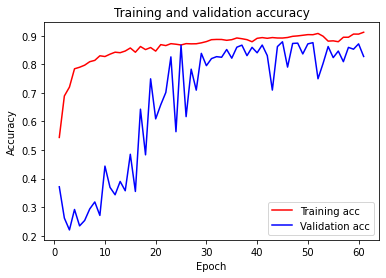

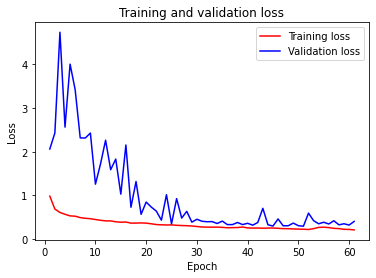

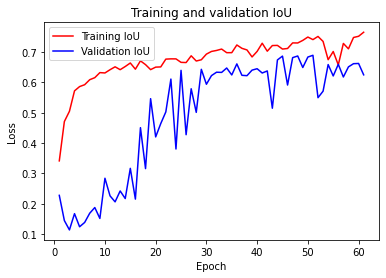

<Figure size 432x288 with 0 Axes>

In [ ]:
# Añadiendo batch normalization

latent_dimension = (53,53,64)
print("Latent dimension shape: {}".format(latent_dimension))
evaluate_model(model, history, trn_x, trn_y, tst_x, tst_y)

Latent dimension shape: (53, 53, 64)
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 214, 214, 3)]     0         
_________________________________________________________________
normalization_3 (Normalizati (None, 214, 214, 3)       7         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 214, 214, 64)      1792      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 214, 214, 64)      36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 107, 107, 64)      0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 107, 107, 64)      256       
_________________________________________________________________
conv2d_17 (Conv2D)    

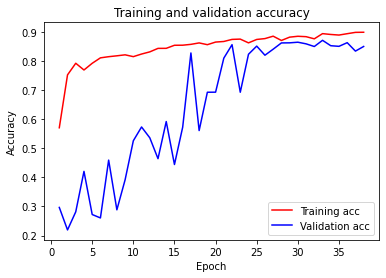

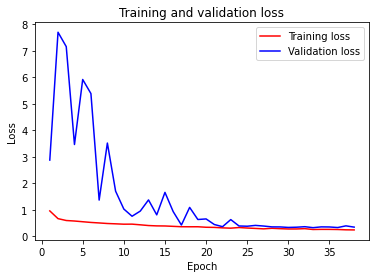

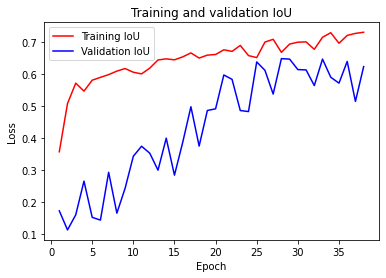

<Figure size 432x288 with 0 Axes>

In [ ]:
# Añadiendo más convoluciones

latent_dimension = (53,53,64)
print("Latent dimension shape: {}".format(latent_dimension))
evaluate_model(model, history, trn_x, trn_y, tst_x, tst_y)

Latent dimension shape: (53, 53, 64)
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 214, 214, 3)]     0         
_________________________________________________________________
normalization_4 (Normalizati (None, 214, 214, 3)       7         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 214, 214, 64)      1792      
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 214, 214, 64)      36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 107, 107, 64)      0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 107, 107, 64)      256       
_________________________________________________________________
conv2d_24 (Conv2D)    

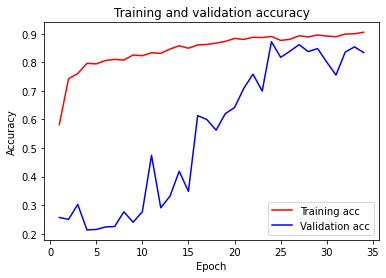

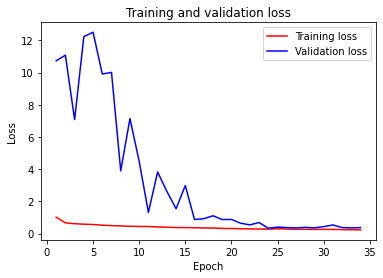

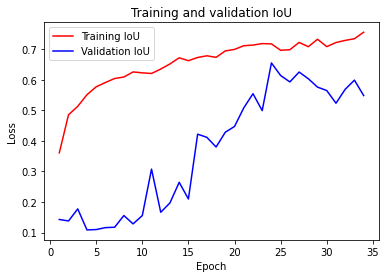

<Figure size 432x288 with 0 Axes>

In [ ]:
# Añadiendo más capas de deconvolucion

latent_dimension = (53,53,64)
print("Latent dimension shape: {}".format(latent_dimension))
evaluate_model(model, history, trn_x, trn_y, tst_x, tst_y)

Latent dimension shape: (53, 53, 64)
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 214, 214, 3)]     0         
_________________________________________________________________
normalization_5 (Normalizati (None, 214, 214, 3)       7         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 214, 214, 64)      1792      
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 214, 214, 64)      36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 107, 107, 64)      0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 107, 107, 64)      256       
_________________________________________________________________
conv2d_31 (Conv2D)    

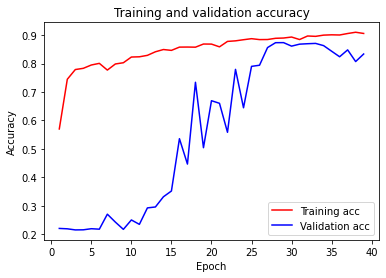

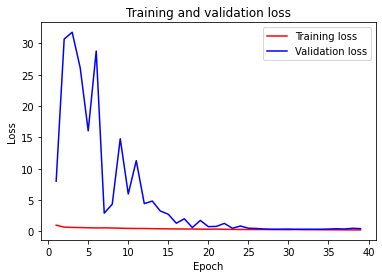

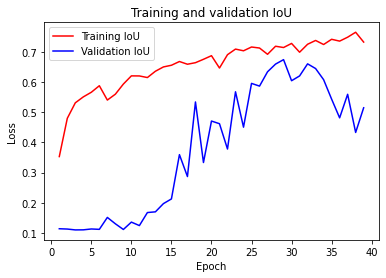

<Figure size 432x288 with 0 Axes>

In [ ]:
# Con stride 1
latent_dimension = (53,53,64)
print("Latent dimension shape: {}".format(latent_dimension))

evaluate_model(model, history, trn_x, trn_y, tst_x, tst_y)

Latent dimension shape: (53, 53, 64)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 214, 214, 3)]     0         
_________________________________________________________________
normalization_1 (Normalizati (None, 214, 214, 3)       7         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 214, 214, 64)      1792      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 107, 107, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 107, 107, 64)      36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 53, 53, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)     

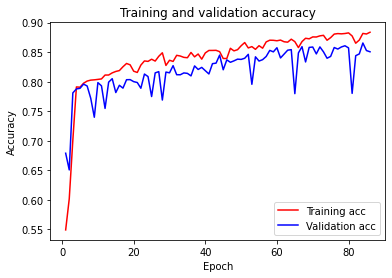

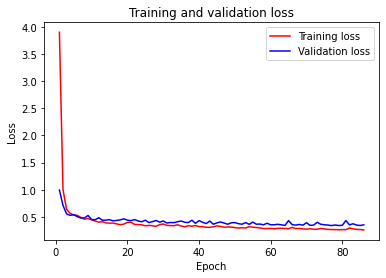

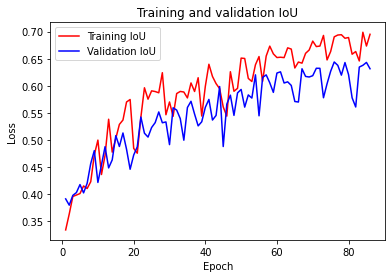

<Figure size 432x288 with 0 Axes>

In [ ]:
# Con stride 1 - sin batchNormalization
latent_dimension = (53,53,64)
print("Latent dimension shape: {}".format(latent_dimension))

evaluate_model(model, history, trn_x, trn_y, tst_x, tst_y)

Latent dimension shape: (53, 53, 64)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 214, 214, 3)]     0         
_________________________________________________________________
normalization_1 (Normalizati (None, 214, 214, 3)       7         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 214, 214, 128)     3584      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 214, 214, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 107, 107, 128)     0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 107, 107, 128)     147584    
_________________________________________________________________
conv2d_10 (Conv2D)    

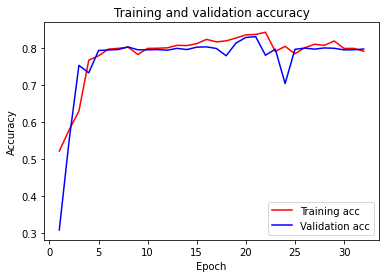

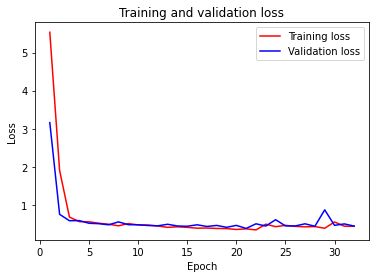

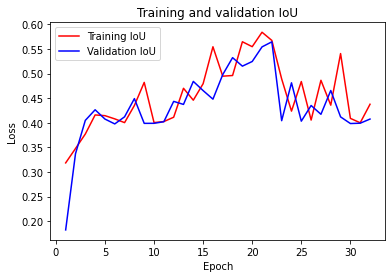

<Figure size 432x288 with 0 Axes>

In [15]:
# Anterior, más unidades

latent_dimension = (53,53,64)
print("Latent dimension shape: {}".format(latent_dimension))

evaluate_model(model, history, trn_x, trn_y, tst_x, tst_y)

Latent dimension shape: (53, 53, 64)
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 214, 214, 3)]     0         
_________________________________________________________________
normalization_2 (Normalizati (None, 214, 214, 3)       7         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 214, 214, 128)     3584      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 214, 214, 128)     147584    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 107, 107, 128)     0         
_________________________________________________________________
dropout (Dropout)            (None, 107, 107, 128)     0         
_________________________________________________________________
conv2d_16 (Conv2D)    

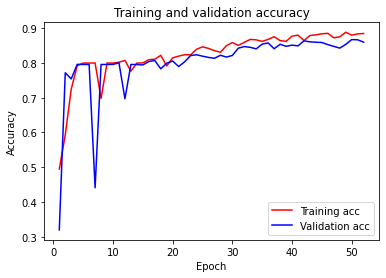

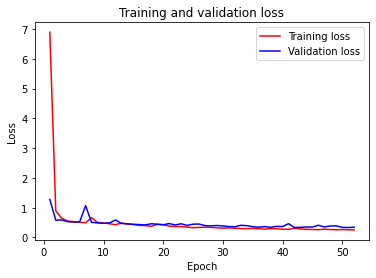

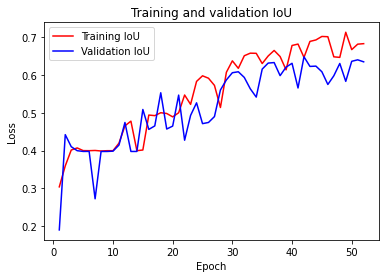

<Figure size 432x288 with 0 Axes>

In [21]:
# Anterior, añadiendo dropout

latent_dimension = (53,53,128)
print("Latent dimension shape: {}".format(latent_dimension))

evaluate_model(model, history, trn_x, trn_y, tst_x, tst_y)

Latent dimension shape: (106, 106, 64)
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 214, 214, 3)]     0         
_________________________________________________________________
normalization_7 (Normalizati (None, 214, 214, 3)       7         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 214, 214, 128)     3584      
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 214, 214, 128)     147584    
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 107, 107, 128)     0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 107, 107, 128)     0         
_________________________________________________________________
conv2d_47 (Conv2D)  

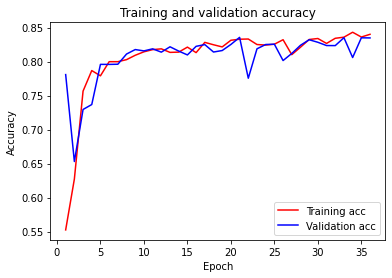

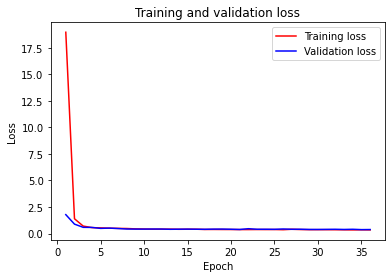

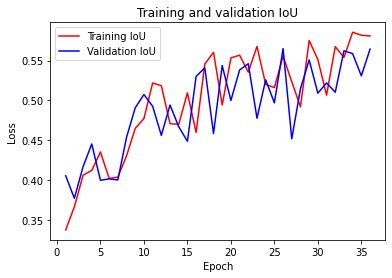

<Figure size 432x288 with 0 Axes>

In [30]:
# Subiendo un nivel de profundidad

latent_dimension = (107,107,128)
print("Latent dimension shape: {}".format(latent_dimension))

evaluate_model(model, history, trn_x, trn_y, tst_x, tst_y)

Latent dimension shape: (106, 106, 128)
Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 214, 214, 3)]     0         
_________________________________________________________________
normalization_22 (Normalizat (None, 214, 214, 3)       7         
_________________________________________________________________
conv2d_176 (Conv2D)          (None, 214, 214, 128)     3584      
_________________________________________________________________
conv2d_177 (Conv2D)          (None, 214, 214, 128)     147584    
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 107, 107, 128)     0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 107, 107, 128)     0         
_________________________________________________________________
conv2d_178 (Conv2D

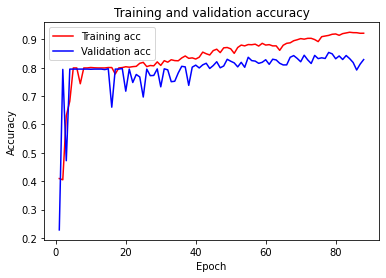

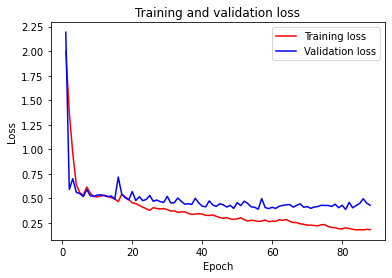

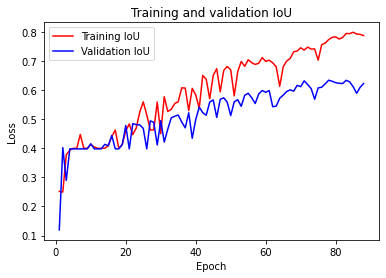

<Figure size 432x288 with 0 Axes>

In [48]:
# Bajando un nivel de profundidad

latent_dimension = (26,26,128)
print("Latent dimension shape: {}".format(latent_dimension))

evaluate_model(model, history, trn_x, trn_y, tst_x, tst_y)